# Time-Varying Graph

In this case, we do not simulate the original algorithm, as it is not well-suited for time-varying graphs. Specifically, the power iteration of $D^k$ recursively accumulates past estimates of algebraic connectivity, leading to a **lag in estimation** as the network topology changes over time. This makes the original method ineffective in tracking the dynamic connectivity of the network.

## baseline

The algorithm that estimates algebraic connectivity and the Fiedler vector simultaneously, serves as a baseline for comparison. It is widely used in the connectivity maintenance \cite{sabattini_distributed_2013,kawajiri_coverage_2021} and so on.

In Zhang's method, a centralized model for estimating algebraic connectivity is designed as follows:
$$
    \dot{x} = -k_1 \frac{\boldsymbol{11}^T}{n} x - k_2 Lx - k_3 \left( \frac{||x||_2^2}{n} - 1 \right) x
$$
where $k_1,k_2,k_3 > 0$ are design parameters, $x(0)$ is initialized randomly. The first term is deflation, the second is update and the third is renormalization, the method combines three steps into one differential equation. The conditions for the convergence of the state variable $x$ to the Fiedler vector $v_2$ are  $k_1 \ge k_2\lambda_2$ and $k_3 > k_2\lambda_2$ Zhang's method.

In Zhang's method, the high-pass consensus filter $\dot y = \dot x - \varepsilon_1 Ly$ is adopted to reduce the number of parameters and improve the convergence speed. The distributed estimation of algebraic connectivity is then described by the following system of equations:
$$
    \begin{cases}
        \dot x = -k_1y - k_2Lx - k_3z\circ x                     \\
        \dot y = (-k_1y - k_2Lx - k_3z\circ x) - \varepsilon_1Ly \\
        \dot z = 2 x \circ (-k_1y - k_2Lx - k_3z\circ x) - \varepsilon_2 Lz
    \end{cases}
$$
where $\circ$ denotes the pointwise multiplication operator ($\boldsymbol{a \circ b} = [a_1 b_1, \cdots, a_n b_n]^T$), with $y(0) = x(0)$ and $z(0) = x(0) \circ x(0) - 1$. The parameters $\varepsilon_1$ and $\varepsilon_2$ are design constants.

The discrete form of this algorithm is given by:
$$
    \begin{cases}
        \begin{aligned}
            \Delta x_i(k) & = -k_1y_i(k) -k_3z_i(k)x_i(k)   \\ & -k_2 \sum_{j \in \mathcal{N}_i}a_{ij}(x_i(k)-x_j(k))\\
            x_i(k+1)      & =x_i(k) + \Delta x_i(k)         \\
            y_i(k+1)      & =y_i(k) +\Delta x_i(k)          \\ & - \varepsilon_1 \sum_{j \in \mathcal{N}_i}a_{ij}(y_i(k)-y_j(k)) \\
            z_i(k+1)      & =z_i(k) + 2x_i(k) \Delta x_i(k) \\ & -\varepsilon_2 \sum_{j \in \mathcal{N}_i}a_{ij}(z_i(k)-z_j(k))
        \end{aligned}
    \end{cases}
$$
Since equation is nonlinear, analyzing the convergence conditions is challenging. In the simulations, the parameters are defined as $k_1=k_3=0.2n/(n+1)$, $k_2=\varepsilon_1=\varepsilon_2=0.2/(n+1)$.

## Graph
$$
    A(0)=\begin{bmatrix}
        0     & 0.407 & 0.501 & 0.055 & 0.085 & 0     \\
        0.407 & 0     & 0.672 & 0     & 0     & 0.207 \\
        0.501 & 0.672 & 0     & 0     & 0.199 & 0.454 \\
        0.055 & 0     & 0     & 0     & 0.462 & 0     \\
        0.085 & 0     & 0.199 & 0.462 & 0     & 0.157 \\
        0     & 0.207 & 0.454 & 0     & 0.157 & 0     \\
    \end{bmatrix}
$$
$$
A(1000)=\begin{bmatrix}
        0     & 0.88  & 0.829 & 0.797 & 0     & 0     \\
        0.88  & 0     & 0.835 & 0     & 0     & 0.851 \\
        0.829 & 0.835 & 0     & 0.871 & 0.857 & 0.825 \\
        0.797 & 0     & 0.871 & 0     & 0.7   & 0     \\
        0     & 0     & 0.857 & 0.7   & 0     & 0.748 \\
        0     & 0.851 & 0.825 & 0     & 0.748 & 0
    \end{bmatrix}
$$
    
$$
A(k)=[1-(1-k/1000)^2]A(0)+(1-k/1000)^2A(1000)
$$

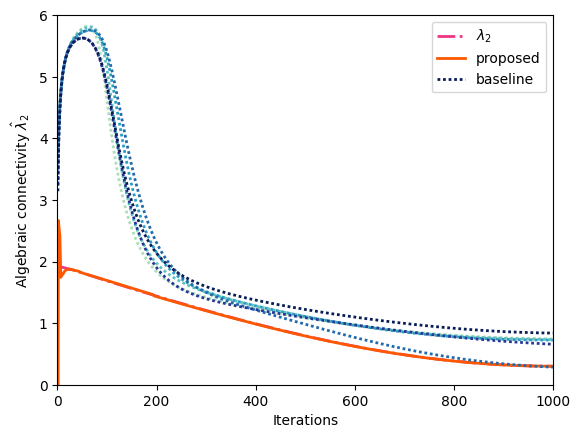

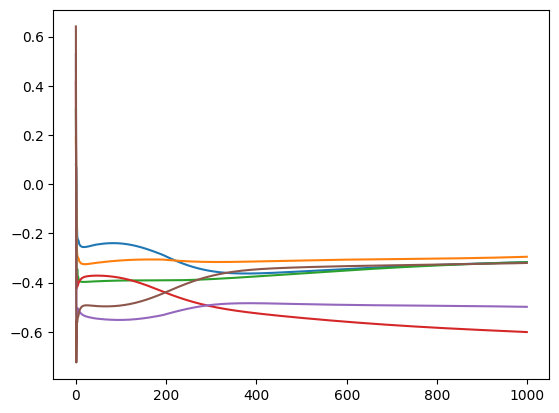

In [2]:
from matplotlib import pyplot as plt
from matplotlib.axes import Axes
import numpy as np
from Algorithms import  StepV2, IterFielder, IterFielderAndConnectivity
from A import N, TimeVarying2
import matplotlib as mpl

ext = "png"
IterTimes = 1000
# improved init
beta = 1 / (2 * N)
k1 = 1 / N
eps = 1 / N
k2 = N  # 0.4


Dk = np.eye(N)
DkV2 = np.eye(N)
connectivity_est = 1
X = np.linspace(0.1, 0.8, N)
Y = X

# baseline, the coefficients of the method is hard to determine.
k1_ = k3_ = 0.2 * N / (N + 1)
k2_ = eps1 = eps2 = 0.2 / (N + 1)
X_ = np.linspace(0.6, 0.8, N)
Y_ = X_
Z_ = X_ * X_ - 1


# store middle values
connectivitys = np.zeros(IterTimes)
connectivitysBaseline = np.zeros((IterTimes, N))
connectivitys[0] = connectivity_est
NormXs = np.zeros((IterTimes, N))
NormXs[0, :] = X / np.linalg.norm(X, ord=2)
eigs = np.zeros(IterTimes)

for i in range(1, IterTimes):
    L = TimeVarying2(i, IterTimes)
    D = np.eye(N) - beta * L
    eig, _ = np.linalg.eigh(L)
    eigs[i] = eig[1]

    DkV2, connectivity_est = StepV2(D, DkV2, connectivity_est, beta)
    k2 = 1.01 * np.abs(connectivity_est)
    X, Y = IterFielder(L, X, Y, connectivity_est, k1, k2, eps)
    connectivitys[i] = connectivity_est
    NormXs[i, :] = X / np.linalg.norm(X, ord=2)
    # baseline
    X_, Y_, Z_, connectivity_baseline = IterFielderAndConnectivity(
        L, X_, Y_, Z_, k1_, k2_, k3_, eps1, eps2
    )
    connectivitysBaseline[i, :] = connectivity_baseline


f, ax = plt.subplots()
ax: Axes = ax
cmap = mpl.colormaps["YlGnBu"]
colors = cmap(np.linspace(0.3, 1, N))
t = np.arange(IterTimes)
denseDotted = (0, (1, 1))
width = 2

ax.plot(
    t[1:],
    eigs[1:],
    color="#F13484",
    label="$\\lambda_2$",
    linestyle="-.",
    linewidth=width,
)
ax.plot(t, connectivitys, label="proposed", color="#FD5700", linewidth=width)
for i in range(N):
    if i == N - 1:
        ax.plot(
            t[1:],
            connectivitysBaseline[1:, i],
            color=colors[i],
            label="baseline",
            linestyle=denseDotted,
            linewidth=width,
        )
    else:
        ax.plot(
            t[1:],
            connectivitysBaseline[1:, i],
            color=colors[i],
            linestyle=denseDotted,
            linewidth=width,
        )
ax.set_ylim([0, 6])
ax.set_xlim([0, IterTimes])
ax.legend()
ax.set_ylabel("Algebraic connectivity $\\hat\\lambda_2$")
ax.set_xlabel("Iterations")


f, ax = plt.subplots()
for i in range(N):
    ax.plot(t, NormXs[:, i])
    # ax.axhline(-eigv[i, 1], linestyle="-.")
plt.show()


Figure illustrates the estimated time-varying algebraic connectivity. The dotted lines represent the results of the baseline method, with each agent depicted in a distinct color. The proposed method converges in 200 iterations and accurately tracks the actual algebraic connectivity. In contrast, the baseline method converges more slowly, with five out of six agents lagging behind the actual algebraic connectivity.